In [106]:
import os
import ast
import pandas as pd
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
%matplotlib inline

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torch import optim
from torchvision.transforms import ToTensor
import albumentations as A

In [107]:
lr = 1e-4
test_size = 0.2
device = 'cuda' if torch.cuda.is_available() else 'cpu'

batch_size = 4
Epochs = 5
DATAPATH = '/home/nekozo/newSpace/modelData/global-wheat-detection'

In [108]:
# 读取数据
df = pd.read_csv(DATAPATH + "/train.csv")
df.bbox = df.bbox.apply(ast.literal_eval)

df = df.groupby("image_id")["bbox"].apply(list).reset_index(name='bboxes')
print(df.head)

<bound method NDFrame.head of        image_id                                             bboxes
0     00333207f  [[0, 654, 37, 111], [0, 817, 135, 98], [0, 192...
1     005b0d8bb  [[765.0, 879.0, 116.0, 79.0], [84.0, 539.0, 15...
2     006a994f7  [[437.0, 988.0, 98.0, 36.0], [309.0, 527.0, 11...
3     00764ad5d  [[89.0, 256.0, 113.0, 107.0], [216.0, 282.0, 1...
4     00b5fefed  [[709.0, 97.0, 204.0, 105.0], [775.0, 250.0, 1...
...         ...                                                ...
3368  ffb445410  [[0.0, 534.0, 54.0, 118.0], [0.0, 480.0, 38.0,...
3369  ffbf75e5b  [[0, 697, 21, 58], [104, 750, 77, 75], [65, 84...
3370  ffbfe7cc0  [[256.0, 0.0, 64.0, 99.0], [390.0, 0.0, 48.0, ...
3371  ffc870198  [[447.0, 976.0, 78.0, 48.0], [18.0, 141.0, 218...
3372  ffdf83e42  [[306.0, 178.0, 67.0, 88.0], [367.0, 167.0, 63...

[3373 rows x 2 columns]>


In [109]:
# 数据集划分
def train_test_split(df, test_size):
    train_data, val_data = df.iloc[:int((1-test_size)*len(df))], df.iloc[int((1-test_size)*len(df)):]
    return train_data, val_data

print(len(df))

trn_df, val_df = train_test_split(df, test_size)
print(len(trn_df), len(val_df))
print(trn_df.head)

3373
2698 675
<bound method NDFrame.head of        image_id                                             bboxes
0     00333207f  [[0, 654, 37, 111], [0, 817, 135, 98], [0, 192...
1     005b0d8bb  [[765.0, 879.0, 116.0, 79.0], [84.0, 539.0, 15...
2     006a994f7  [[437.0, 988.0, 98.0, 36.0], [309.0, 527.0, 11...
3     00764ad5d  [[89.0, 256.0, 113.0, 107.0], [216.0, 282.0, 1...
4     00b5fefed  [[709.0, 97.0, 204.0, 105.0], [775.0, 250.0, 1...
...         ...                                                ...
2693  cbbc58a4c  [[108.0, 63.0, 88.0, 228.0], [0.0, 299.0, 113....
2694  cbfaa3ed9  [[532.0, 929.0, 138.0, 74.0], [194.0, 491.0, 8...
2695  cbfd50139  [[3, 84, 117, 99], [96, 1, 87, 80], [0, 177, 5...
2696  cc1a14dfc  [[622.0, 494.0, 125.0, 122.0], [836.0, 316.0, ...
2697  cc236443b  [[643.0, 13.0, 69.0, 77.0], [356.0, 88.0, 82.0...

[2698 rows x 2 columns]>


In [110]:
# 稻穗数据集
class wheatDataset(Dataset):
    def __init__(self, df, root, train_mode=True):
        self.df = df
        self.root = root
        self.image_names = self.df["image_id"].values
        self.bboxes = self.df["bboxes"].values
        self.isTrain = train_mode
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        print(self.image_names[idx])
        img_path = os.path.join(self.root, self.image_names[idx] + '.jpg')
        print(img_path)
        img = cv.imread(img_path, cv.IMREAD_COLOR)
        print(type(img))
        img = cv.cvtColor(img, cv.COLOR_BGR2RGB).astype(np.float32)  # BGR2RGB  
        img = img / 255.0
        bboxes = torch.tensor(self.bboxes[idx], dtype=torch.float64)
        
        # (xmin, ymin, width, height) -> (xmin, ymin, xmax, ymax)
        bboxes[:, 2] = bboxes[:, 0] + bboxes[:, 2]
        bboxes[:, 3] = bboxes[:, 1] + bboxes[:, 3]
        
        
        # calculate area
        area = (bboxes[:, 3] - bboxes[:, 1]) * (bboxes[:, 2] - bboxes[:, 0])
        area = torch.as_tensor(area, dtype=torch.float32)
        
        
        lbls = torch.ones((len(bboxes), ), dtype=torch.int64)
        iscrowded = torch.zeros((len(bboxes), ), dtype=torch.int64)
        
        target = {}
        target['boxes'] = bboxes
        target["labels"] = lbls
        target["image_id"] = torch.tensor([idx])
        target["area"] = area
        target["iscrowed"] = iscrowded
        
        sample = {
            "image": img,
            "bboxes": target["boxes"],
            "labels": lbls,
        } 
        sample = **sample
        if self.isTrain:
            TODO:"用不同的transform处理train和validation的数据"
            
        img = sample["image"]
        
        target["boxes"] = torch.stack(tuple(map(torch.tensor, zip(*sample["bboxes"])))).permute(1, 0)
    
        return img, target

In [111]:
train_transform = A.Compose([  
    A.Flip(0.5),  
    ToTensor(),
],bbox_params = {'format':"pascal_voc",'label_fields': ['labels']}) 

val_transform = A.Compose([  
    ToTensor(),  
],bbox_params = {'format':"pascal_voc","label_fields":['labels']})  

def collate_fn(batch):
    return tuple(zip(*batch))

00333207f
/home/nekozo/newSpace/modelData/global-wheat-detection/train/00333207f.jpg
<class 'numpy.ndarray'>
(1024, 1024, 3)


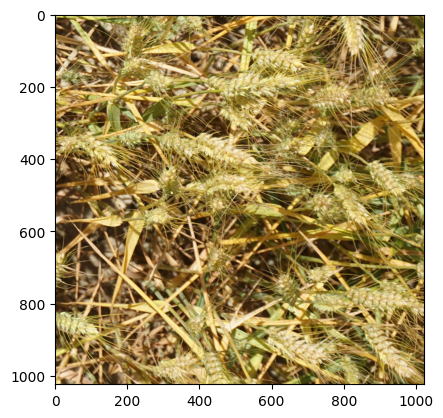

In [112]:
trn_ds = wheatDataset(trn_df, DATAPATH + "/train", transform=train_transform)
val_ds = wheatDataset(val_df, DATAPATH + "/train", transform=val_transform)

image, target = trn_ds.__getitem__(0)
plt.imshow(image)
print(image.shape)

In [113]:
# 定义模型 
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor

model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)

num_classes = 2
in_features = model.roi_heads.box_predictor.cls_score.in_features
model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

/home/nekozo/newSpace/anaconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/nekozo/newSpace/anaconda3/envs/pytorch/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=FasterRCNN_ResNet50_FPN_Weights.COCO_V1`. You can also use `weights=FasterRCNN_ResNet50_FPN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [114]:
class Averager:
    def __init__(self):
        self.cur_total = 0.0
        self.iterations = 0.0
    
    def send(self, value):
        self.cur_total += value
        self.iterations += 1
    
    @property
    def value(self):
        if self.iterations == 0:
            return 0
        else:
            return 1.0 * self.cur_total / self.iterations
        
    def reset(self):
        self.cur_total = 0.0
        self.iterations = 0.0

In [115]:
trn_dl = DataLoader(trn_ds, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
val_dl = DataLoader(val_ds, batch_size=batch_size, shuffle=False, collate_fn=collate_fn)

In [116]:
trn_loss = []
model = model.to(device)
params =  [p for p in model.parameters() if p.requires_grad]    
opt = optim.Adam(params, lr)
loss_hist = Averager()
iters = 1
lr_scheduler = None

In [119]:
for epoch in range(Epochs):
    loss_hist.reset()
    
    for images, targets in trn_dl:
        images = list(image.to(device) for image in images)
        targets = [{k:v.to(device) for k, v in t.items()} for t in targets]
        
        loss_dict = model(images, targets)
        losses = sum(loss for loss in loss_dict.values())
        loss_value = losses.item()
        
        loss_hist.send(loss_value)
        
        opt.zero_grad()
        losses.backward()
        opt.step()
        
        if iters % 50 == 0:
            print(f"Iteration {iters} loss: {loss_value}")
        
        iters += 1
        
    if lr_scheduler is not None:
        lr_scheduler.step()
        
    print(f"Epoch {epoch} loss: {loss_hist.value}")

19c242397
/home/nekozo/newSpace/modelData/global-wheat-detection/train/19c242397.jpg
<class 'numpy.ndarray'>
96fa00d50
/home/nekozo/newSpace/modelData/global-wheat-detection/train/96fa00d50.jpg
<class 'numpy.ndarray'>
93224e554
/home/nekozo/newSpace/modelData/global-wheat-detection/train/93224e554.jpg
<class 'numpy.ndarray'>
afe608129
/home/nekozo/newSpace/modelData/global-wheat-detection/train/afe608129.jpg
<class 'numpy.ndarray'>


AttributeError: 'list' object has no attribute 'to'

In [ ]:
# 模型保存  
torch.save(model.state_dict(), 'fasterrcnn_resnet50_fpn.pth')  